In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 54.3 MB/s eta 0:00:00


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, jaccard_score, ConfusionMatrixDisplay
from torchsummary import summary
import rasterio
from rasterio.plot import show
import torch
import torch.nn as nn
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from pathlib import Path

In [ ]:
IMAGES_PATH = '/content/drive/MyDrive/images/'
LABELS_PATH = '/content/drive/MyDrive/labels/'

In [ ]:
class WaterBodyDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None, label_transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.label_transform = label_transform

        self.image_files = sorted([f for f in os.listdir(images_dir)
                                  if f.endswith('.png')])

        self.label_files = sorted([f for f in os.listdir(labels_dir)
                                  if f.endswith('.png')])

        assert len(self.image_files) == len(self.label_files), "Number of images and labels don't match!"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        label_path = os.path.join(self.labels_dir, self.label_files[idx])
        label = Image.open(label_path)

        if self.transform:
            image = self.transform(image)

        if self.label_transform:
            label = self.label_transform(label)

        return image, label

In [ ]:
image_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

mask_transforms = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

In [ ]:
full_dataset = WaterBodyDataset(
    IMAGES_PATH,
    LABELS_PATH,
    transform=image_transforms,
    label_transform=mask_transforms
)

In [ ]:
def create_splits(dataset, train_count=300, val_count=32, test_count=32, random_seed=None):
    dataset_size = len(dataset)
    total_requested = train_count + val_count + test_count

    if total_requested > dataset_size:
        raise ValueError(f"Requested Total of {total_requested} exceeds Dataset size of {dataset_size}.")

    indices = np.random.RandomState(seed=random_seed).permutation(dataset_size)

    train_indices = indices[:train_count]
    val_indices = indices[train_count:train_count + val_count]
    test_indices = indices[train_count + val_count:train_count + val_count + test_count]

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    print(f"Train set: {len(train_dataset)}")
    print(f"Val set: {len(val_dataset)}")
    print(f"Test set: {len(test_dataset)}")

    return train_dataset, val_dataset, test_dataset

In [ ]:
train_dataset, val_dataset, test_dataset = create_splits(
    full_dataset
)

Train set: 300
Val set: 32
Test set: 32


In [ ]:
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=10, num_workers=2):

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader



In [ ]:
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset,
    val_dataset,
    test_dataset,
    batch_size=10
)

In [ ]:
def visualize_dataset_samples(dataset, title, num_samples=3):
    temp_loader = DataLoader(dataset, batch_size=1, shuffle=True)

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4*num_samples))
    fig.suptitle(f"{title} - Sample Images and Masks", fontsize=16)

    samples = []
    for i, (image, mask) in enumerate(temp_loader):
        if i >= num_samples:
            break
        samples.append((image[0], mask[0]))

    for i, (image, mask) in enumerate(samples):
        img = image.clone()
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        msk = mask.permute(1, 2, 0).numpy()

        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(msk, cmap='gray')
        axes[i, 1].set_title(f"Mask {i+1}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

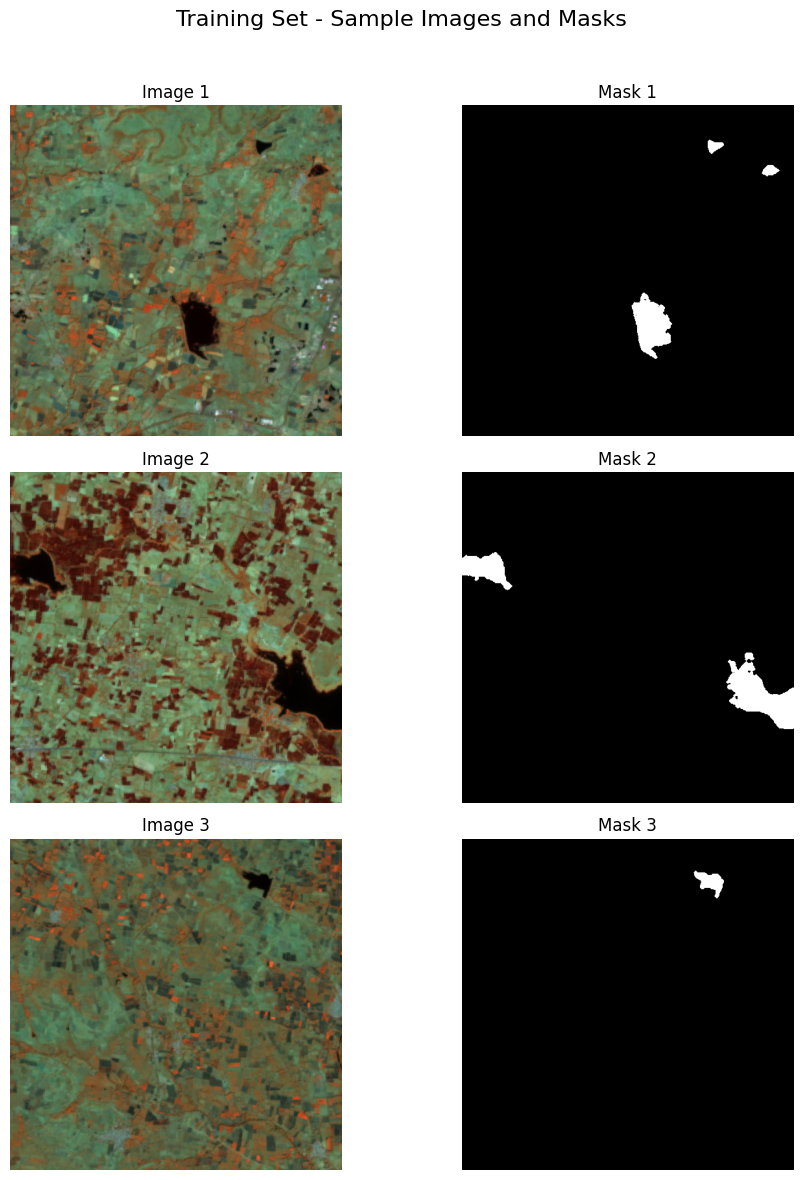

In [ ]:
visualize_dataset_samples(train_dataset, "Training Set")

In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        self.inc = DoubleConv(n_channels, 16)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(16, 32))

        self.bottom = nn.Sequential(nn.MaxPool2d(2), DoubleConv(32, 64))

        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.upconv1 = DoubleConv(64, 32)

        self.up2 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.upconv2 = DoubleConv(32, 16)

        self.outc = nn.Conv2d(16, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.bottom(x2)

        x = self.up1(x3)
        x = self.upconv1(torch.cat([x2, x], dim=1))

        x = self.up2(x)
        x = self.upconv2(torch.cat([x1, x], dim=1))

        logits = self.outc(x)
        return torch.sigmoid(logits)


In [ ]:
model = UNet(n_channels=3, n_classes=1)

summary(model, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]             448
       BatchNorm2d-2         [-1, 16, 512, 512]              32
              ReLU-3         [-1, 16, 512, 512]               0
            Conv2d-4         [-1, 16, 512, 512]           2,320
       BatchNorm2d-5         [-1, 16, 512, 512]              32
              ReLU-6         [-1, 16, 512, 512]               0
        DoubleConv-7         [-1, 16, 512, 512]               0
         MaxPool2d-8         [-1, 16, 256, 256]               0
            Conv2d-9         [-1, 32, 256, 256]           4,640
      BatchNorm2d-10         [-1, 32, 256, 256]              64
             ReLU-11         [-1, 32, 256, 256]               0
           Conv2d-12         [-1, 32, 256, 256]           9,248
      BatchNorm2d-13         [-1, 32, 256, 256]              64
             ReLU-14         [-1, 32, 2

In [ ]:
def dice_coefficient(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

    return dice

In [ ]:
def iou_score(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    total = (pred + target).sum()
    union = total - intersection

    iou = (intersection + smooth) / (union + smooth)

    return iou

In [ ]:
def pixel_accuracy(pred, target):
    pred = pred.view(-1)
    target = target.view(-1)

    correct = (pred == target).sum().float()
    total = pred.numel()

    accuracy = correct / total

    return accuracy

In [ ]:
def train_model(model, train_loader, val_loader, test_loader, epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using Device: {device}")

    model = model.to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True
    )

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_dice': [],
        'val_dice': [],
        'train_iou': [],
        'val_iou': [],
        'train_accuracy': [],
        'val_accuracy': []
    }

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_iou = 0.0
        train_accuracy = 0.0

        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            pred_masks = (outputs > 0.5).float()
            batch_dice = dice_coefficient(pred_masks, masks)
            batch_iou = iou_score(pred_masks, masks)
            batch_accuracy = pixel_accuracy(pred_masks, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_dice += batch_dice.item() * images.size(0)
            train_iou += batch_iou.item() * images.size(0)
            train_accuracy += batch_accuracy.item() * images.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_dice = train_dice / len(train_loader.dataset)
        train_iou = train_iou / len(train_loader.dataset)
        train_accuracy = train_accuracy / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_iou = 0.0
        val_accuracy = 0.0

        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)

                pred_masks = (outputs > 0.5).float()
                batch_dice = dice_coefficient(pred_masks, masks)
                batch_iou = iou_score(pred_masks, masks)
                batch_accuracy = pixel_accuracy(pred_masks, masks)

                val_loss += loss.item() * images.size(0)
                val_dice += batch_dice.item() * images.size(0)
                val_iou += batch_iou.item() * images.size(0)
                val_accuracy += batch_accuracy.item() * images.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_dice = val_dice / len(val_loader.dataset)
        val_iou = val_iou / len(val_loader.dataset)
        val_accuracy = val_accuracy / len(val_loader.dataset)

        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_dice'].append(train_dice)
        history['val_dice'].append(val_dice)
        history['train_iou'].append(train_iou)
        history['val_iou'].append(val_iou)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}, Accuracy: {train_accuracy:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Accuracy: {val_accuracy:.4f}')

    return model, history


In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_dice'], label='Train Dice')
    plt.plot(history['val_dice'], label='Val Dice')
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_iou'], label='Train IoU')
    plt.plot(history['val_iou'], label='Val IoU')
    plt.title('IoU Score')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title('Pixel Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def visualize_metrics_for_test(model, dataloader, index):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            pred_masks = (outputs > 0.5).float()

            img = images[index].cpu()
            true_mask = masks[index].cpu().squeeze().numpy().astype(np.uint8)
            pred_mask = pred_masks[index].cpu().squeeze().numpy().astype(np.uint8)

            true_flat = true_mask.flatten()
            pred_flat = pred_mask.flatten()

            accuracy = accuracy_score(true_flat, pred_flat)
            precision = precision_score(true_flat, pred_flat, zero_division=0)
            recall = recall_score(true_flat, pred_flat, zero_division=0)
            f1 = f1_score(true_flat, pred_flat, zero_division=0)
            iou = jaccard_score(true_flat, pred_flat, zero_division=0)

            print(f"Pixel-wise Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"IoU: {iou:.4f}")

            cm = confusion_matrix(true_flat, pred_flat)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Water", "Water"])
            disp.plot(cmap='Blues')
            plt.title("Confusion Matrix")
            plt.show()

            img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            img = img.permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(img)
            axes[0].set_title("Input Image")
            axes[0].axis("off")

            axes[1].imshow(true_mask, cmap="gray")
            axes[1].set_title("Ground Truth Mask")
            axes[1].axis("off")

            axes[2].imshow(pred_mask, cmap="gray")
            axes[2].set_title("Predicted Mask")
            axes[2].axis("off")

            plt.tight_layout()
            plt.show()

            break

In [ ]:
model = UNet(n_channels=3, n_classes=1)

In [ ]:
trained_model, history = train_model(model, train_loader, val_loader, test_loader, epochs=5)

Using Device: cpu


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5
Train Loss: 0.5157, Dice: 0.5508, IoU: 0.4434, Accuracy: 0.8943
Val Loss: 0.4300, Dice: 0.8018, IoU: 0.6720, Accuracy: 0.9903
Epoch 2/5
Train Loss: 0.3568, Dice: 0.8461, IoU: 0.7364, Accuracy: 0.9935
Val Loss: 0.3345, Dice: 0.8389, IoU: 0.7281, Accuracy: 0.9916
Epoch 3/5
Train Loss: 0.2854, Dice: 0.8252, IoU: 0.7119, Accuracy: 0.9918
Val Loss: 0.2617, Dice: 0.8145, IoU: 0.6897, Accuracy: 0.9898
Epoch 4/5
Train Loss: 0.2251, Dice: 0.8521, IoU: 0.7451, Accuracy: 0.9937
Val Loss: 0.2125, Dice: 0.8427, IoU: 0.7288, Accuracy: 0.9926
Epoch 5/5
Train Loss: 0.1786, Dice: 0.8578, IoU: 0.7547, Accuracy: 0.9938
Val Loss: 0.1615, Dice: 0.8520, IoU: 0.7445, Accuracy: 0.9931


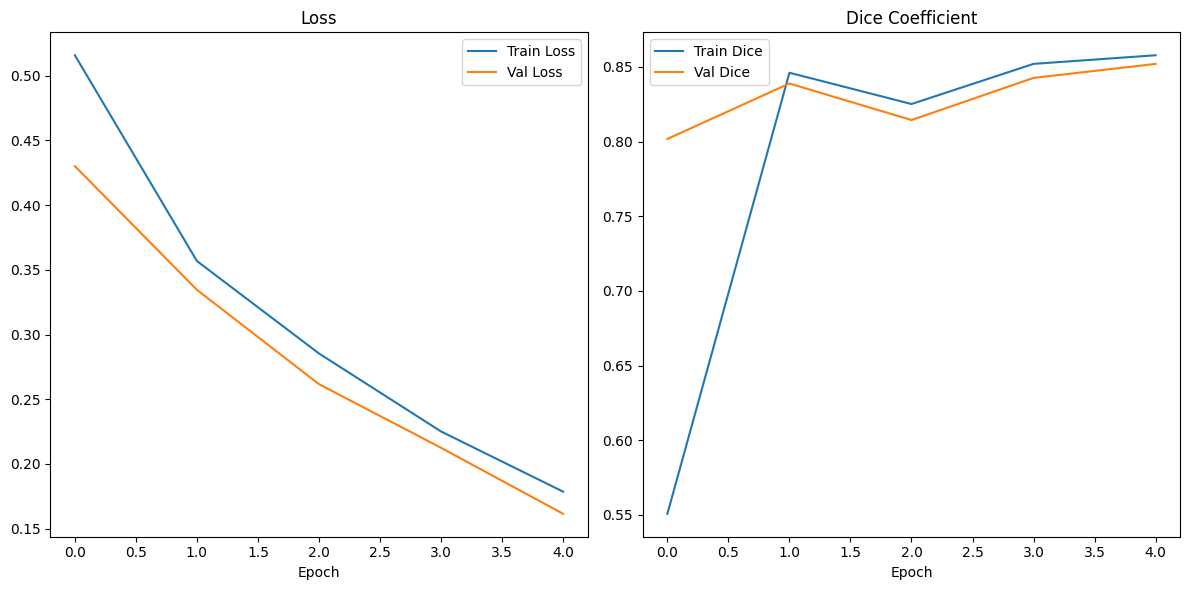

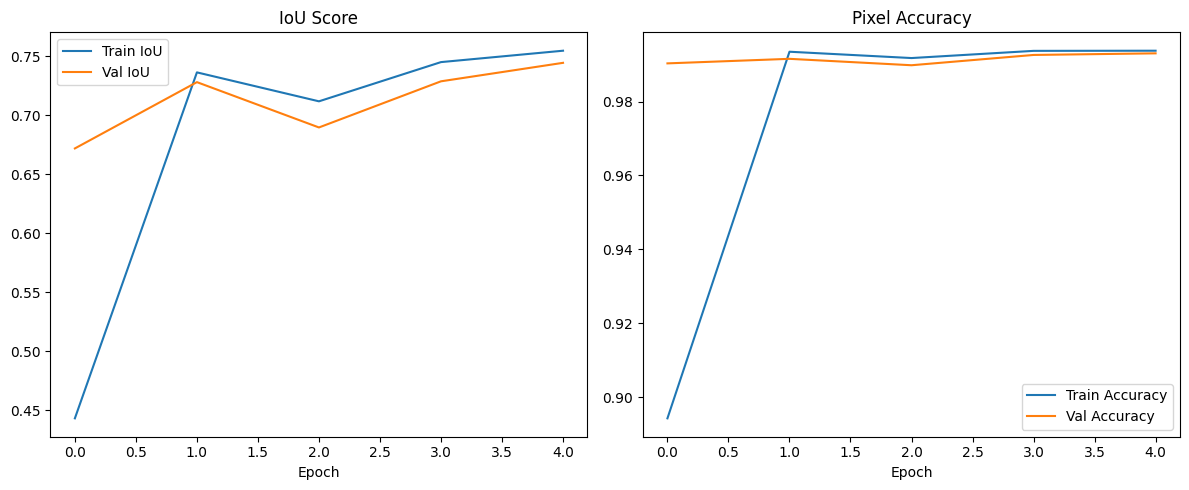

In [ ]:
plot_history(history)

Pixel-wise Accuracy: 0.9838
Precision: 1.0000
Recall: 0.2297
F1 Score: 0.3736
IoU: 0.2297


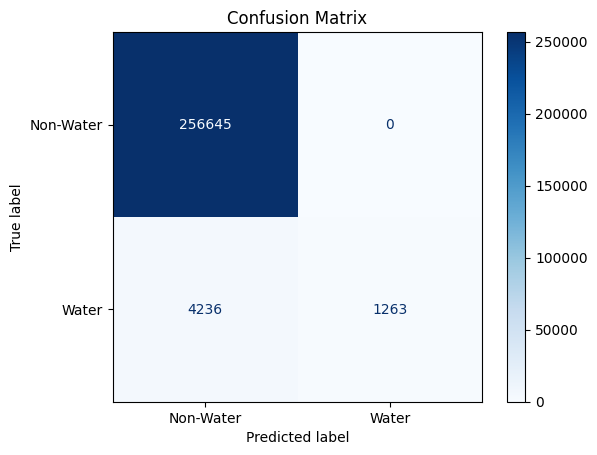

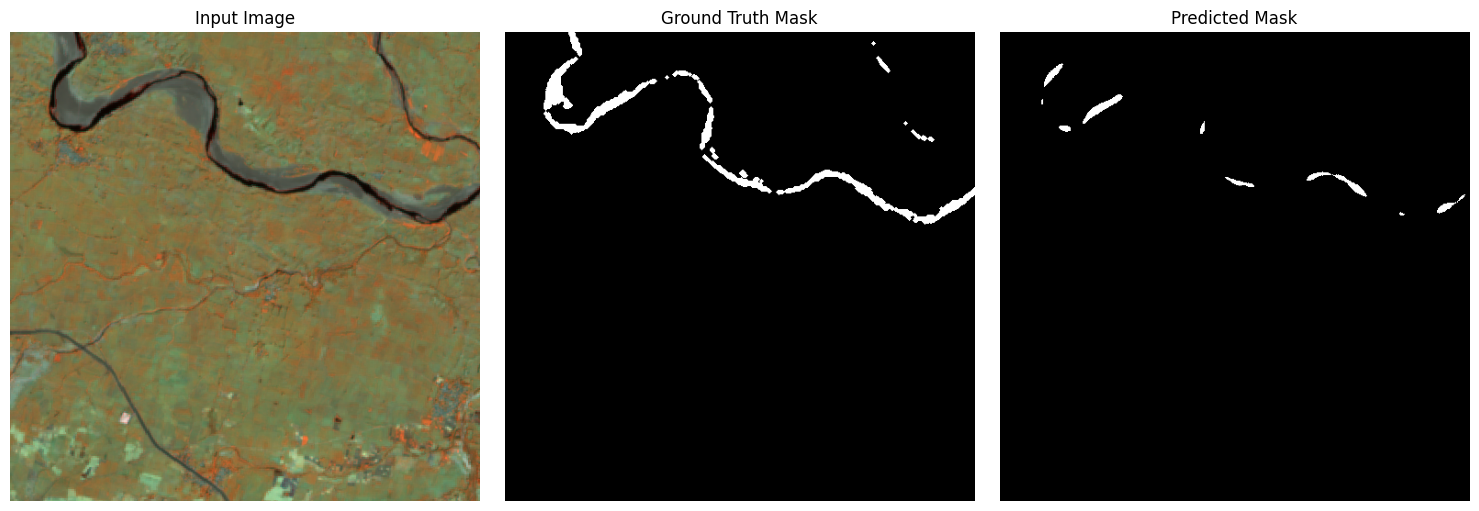

In [ ]:
visualize_metrics_for_test(trained_model, test_loader, 2)

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 80.8 MB/s eta 0:00:00


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
import matplotlib.colors as colors

def visualize_tif_rgb(tif_path, bg_color=[238, 217, 196]):  # Light tan background
    with rasterio.open(tif_path) as src:
        # Read bands: assuming band order is Band 8, 11, 12 in file
        band8 = src.read(1).astype(np.float32)
        band11 = src.read(2).astype(np.float32)
        band12 = src.read(3).astype(np.float32)

        # Get mask of valid data (non-zero or non-NaN values)
        mask = (band8 > 0) & (band11 > 0) & (band12 > 0)
        mask = mask & ~np.isnan(band8) & ~np.isnan(band11) & ~np.isnan(band12)

    # Stack to form RGB (Band 8 = R, Band 11 = G, Band 12 = B)
    rgb = np.stack([band8, band11, band12], axis=-1)

    # Normalize to 0–1 for display
    rgb_min = np.nanmin(rgb)
    rgb_max = np.nanmax(rgb)
    rgb_norm = (rgb - rgb_min) / (rgb_max - rgb_min + 1e-8)
    rgb_norm = np.clip(rgb_norm, 0, 1)

    # Create RGBA image with background color (normalized to 0-1)
    rgba = np.ones((rgb.shape[0], rgb.shape[1], 4))

    # Normalize background color to 0-1 range
    bg_color_norm = [c/255 for c in bg_color]

    # Apply background color to the entire image
    rgba[..., 0] = bg_color_norm[0]
    rgba[..., 1] = bg_color_norm[1]
    rgba[..., 2] = bg_color_norm[2]

    # Fill valid data areas with the normalized rgb values
    rgba[mask, 0] = rgb_norm[mask, 0]
    rgba[mask, 1] = rgb_norm[mask, 1]
    rgba[mask, 2] = rgb_norm[mask, 2]

    # Show image
    plt.figure(figsize=(12, 12))
    plt.imshow(rgba)
    plt.title("RGB Visualization (Band 8, 11, 12)")
    plt.axis("off")
    plt.show()


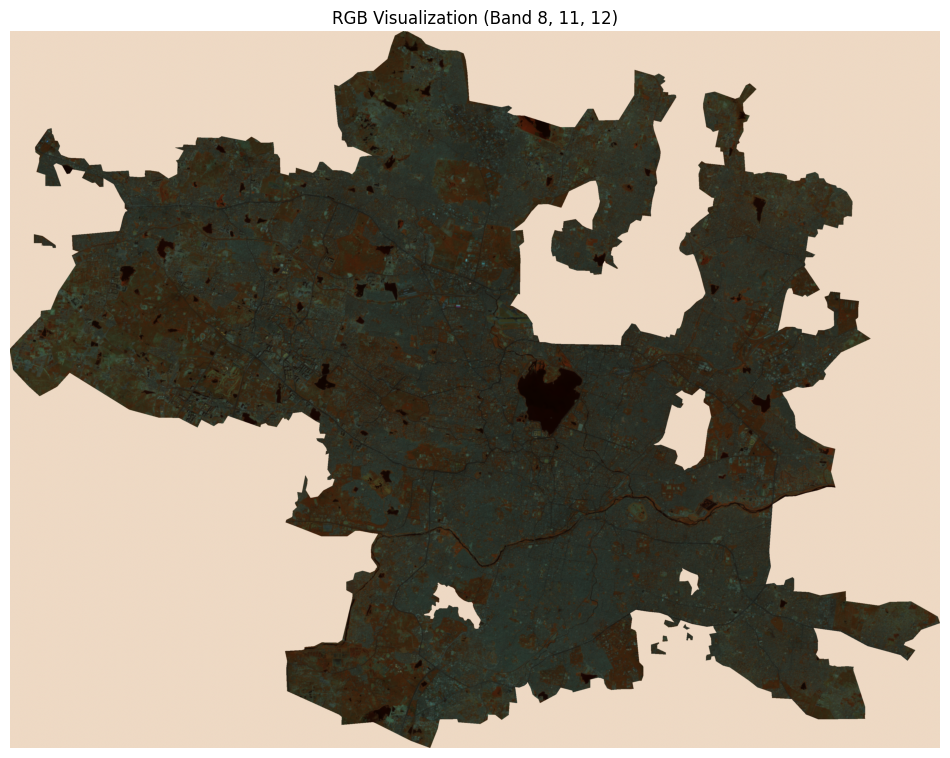

In [ ]:
visualize_tif_rgb("/content/drive/MyDrive/GHMC/GHMC_S2_new.tif")


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology
import matplotlib.colors as mcolors

def classify_dark_pixels(tif_path, dark_percentile=5, min_area=500, max_aspect_ratio=3,
                         line_width_threshold=6):
    with rasterio.open(tif_path) as src:
        band8 = src.read(1).astype(np.float32)
        band11 = src.read(2).astype(np.float32)
        band12 = src.read(3).astype(np.float32)

        # Valid data mask
        mask = (band8 > 0) & (band11 > 0) & (band12 > 0)
        mask &= ~np.isnan(band8) & ~np.isnan(band11) & ~np.isnan(band12)

    # Normalize bands
    rgb = np.stack([band8, band11, band12], axis=-1)
    rgb_min = np.nanmin(rgb)
    rgb_max = np.nanmax(rgb)
    rgb_norm = (rgb - rgb_min) / (rgb_max - rgb_min + 1e-8)
    rgb_norm = np.clip(rgb_norm, 0, 1)

    # Compute intensity
    intensity = np.mean(rgb_norm, axis=-1)
    intensity[~mask] = np.nan

    # Identify darkest pixels
    threshold = np.nanpercentile(intensity, dark_percentile)
    dark_pixels = (intensity <= threshold) & mask
    binary_mask = dark_pixels.astype(np.uint8)

    # Apply morphological operations to remove thin lines
    # First, perform opening to break thin connections
    opened = morphology.opening(binary_mask, morphology.disk(2))

    # Label connected components
    labels = measure.label(opened, connectivity=2)
    props = measure.regionprops(labels)
    filtered = np.zeros_like(binary_mask)

    # Filter based on area, aspect ratio, and width
    for prop in props:
        if prop.area >= min_area:
            if prop.minor_axis_length > 0:
                aspect_ratio = prop.major_axis_length / prop.minor_axis_length
                # Check if the feature is too thin (line-like)
                is_thin_line = prop.minor_axis_length < line_width_threshold and aspect_ratio > max_aspect_ratio
            else:
                is_thin_line = True
                aspect_ratio = np.inf

            if not is_thin_line and aspect_ratio < max_aspect_ratio:
                filtered[labels == prop.label] = 1

    classification = np.full_like(filtered, fill_value=-1, dtype=np.int8)
    classification[mask] = 0
    classification[filtered == 1] = 1

    # Create custom colormap with the specified tan color for -1 values
    tan_color = np.array([238, 217, 196]) / 255.0  # Normalize to 0-1 range
    white_color = np.array([1.0, 1.0, 1.0])
    black_color = np.array([0.0, 0.0, 0.0])

    # Create a colormap with these three colors
    colors_list = [tan_color, black_color, white_color]
    custom_cmap = mcolors.ListedColormap(colors_list)

    bounds = [-1.5, -0.5, 0.5, 1.5]
    norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)

    plt.figure(figsize=(12, 12))
    plt.imshow(classification, cmap=custom_cmap, norm=norm)
    plt.title(f"Classified Map of GHMC Region")
    plt.axis("off")
    plt.show()


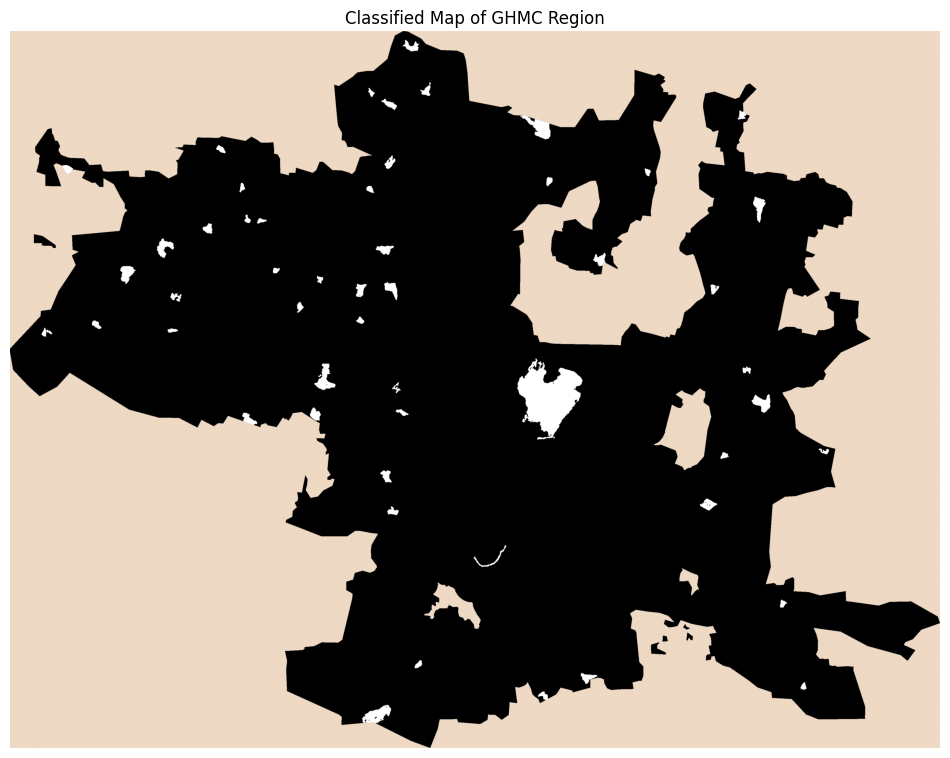

In [ ]:
classify_dark_pixels("/content/drive/MyDrive/GHMC/GHMC_S2_new.tif")

In [ ]:
def predict_large_image(model, tif_path, output_path=None, patch_size=512, overlap=64, batch_size=4):
    import torch
    import numpy as np
    import rasterio

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    with rasterio.open(tif_path) as src:
        meta = src.meta.copy()
        height, width = src.height, src.width

        print(f"Reading bands from {tif_path}...")
        band8 = src.read(1).astype(np.float32)
        band11 = src.read(2).astype(np.float32)
        band12 = src.read(3).astype(np.float32)

        rgb = np.stack([band8, band11, band12], axis=0)

        valid_mask = ~np.isnan(rgb[0]) & (rgb[0] != 0) & ~np.isnan(rgb[1]) & (rgb[1] != 0) & ~np.isnan(rgb[2]) & (rgb[2] != 0)

    rgb_min = np.nanmin(rgb)
    rgb_max = np.nanmax(rgb)
    rgb_norm = (rgb - rgb_min) / (rgb_max - rgb_min)
    rgb_norm = np.clip(rgb_norm, 0, 1)

    rgb_norm = np.nan_to_num(rgb_norm, nan=0.0)

    # Create a single prediction mask to hold the combined results
    prediction_mask = np.zeros((height, width), dtype=np.float32)
    count_mask = np.zeros((height, width), dtype=np.float32)

    stride = patch_size - overlap
    steps_y = max(1, int(np.ceil((height - patch_size) / stride)) + 1)
    steps_x = max(1, int(np.ceil((width - patch_size) / stride)) + 1)

    print(f"Processing image of size {height}x{width} with {steps_y}x{steps_x} patches...")

    # Process patches in batches
    patches = []
    positions = []

    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            patch = rgb_norm[:, y:y+patch_size, x:x+patch_size]
            patches.append(patch)
            positions.append((y, x))

            if len(patches) == batch_size:
                process_batch(model, patches, positions, prediction_mask, count_mask, patch_size, device)
                patches = []
                positions = []

    if patches:
        process_batch(model, patches, positions, prediction_mask, count_mask, patch_size, device)

    # Process edge cases
    # Bottom edge
    if height % stride != 0:
        y = height - patch_size
        for x in range(0, width - patch_size + 1, stride):
            patch = rgb_norm[:, y:y+patch_size, x:x+patch_size]
            position = (y, x)
            process_batch(model, [patch], [position], prediction_mask, count_mask, patch_size, device)

    # Right edge
    if width % stride != 0:
        x = width - patch_size
        for y in range(0, height - patch_size + 1, stride):
            patch = rgb_norm[:, y:y+patch_size, x:x+patch_size]
            position = (y, x)
            process_batch(model, [patch], [position], prediction_mask, count_mask, patch_size, device)

    # Bottom-right corner
    if height % stride != 0 and width % stride != 0:
        y = height - patch_size
        x = width - patch_size
        patch = rgb_norm[:, y:y+patch_size, x:x+patch_size]
        position = (y, x)
        process_batch(model, [patch], [position], prediction_mask, count_mask, patch_size, device)

    # Average the predictions where patches overlap
    final_mask = np.zeros_like(prediction_mask)
    mask = count_mask > 0
    final_mask[mask] = prediction_mask[mask] / count_mask[mask]

    # Apply valid mask (where we have valid input data)
    final_mask[~valid_mask] = 0

    # Create binary mask from confidence values
    binary_mask = (final_mask > 0.5).astype(np.uint8)

    return binary_mask, final_mask

def process_batch(model, patches, positions, prediction_mask, count_mask, patch_size, device):
    import torch
    import numpy as np

    batch = torch.tensor(np.array(patches), dtype=torch.float32).to(device)

    with torch.no_grad():
        predictions = model(batch).cpu().numpy()

    for i, (y, x) in enumerate(positions):
        pred = predictions[i, 0]  # Assuming single-channel output
        prediction_mask[y:y+patch_size, x:x+patch_size] += pred
        count_mask[y:y+patch_size, x:x+patch_size] += 1

def visualize_results(tif_path, binary_mask, confidence_mask, output_dir=None, bg_color=[0.6, 0.6, 0.6]):
    import numpy as np
    import rasterio
    import matplotlib.pyplot as plt

    with rasterio.open(tif_path) as src:
        band8 = src.read(1).astype(np.float32)
        band11 = src.read(2).astype(np.float32)
        band12 = src.read(3).astype(np.float32)

        valid_mask = ~np.isnan(band8) & (band8 != 0) & ~np.isnan(band11) & (band11 != 0) & ~np.isnan(band12) & (band12 != 0)

        rgb = np.stack([band8, band11, band12], axis=-1)
        rgb_min = np.nanmin(rgb)
        rgb_max = np.nanmax(rgb)
        rgb_norm = (rgb - rgb_min) / (rgb_max - rgb_min + 1e-8)
        rgb_norm = np.clip(rgb_norm, 0, 1)
        rgb_norm = np.nan_to_num(rgb_norm, nan=0.0)

    # Create RGBA image for visualization
    rgba = np.ones((rgb.shape[0], rgb.shape[1], 4))
    rgba[..., 0:3] = bg_color

    rgba[valid_mask, 0] = rgb_norm[valid_mask, 0]
    rgba[valid_mask, 1] = rgb_norm[valid_mask, 1]
    rgba[valid_mask, 2] = rgb_norm[valid_mask, 2]

    fig, axs = plt.subplots(1, 3, figsize=(20, 10))

    axs[0].imshow(rgba)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(binary_mask, cmap='gray')
    axs[1].set_title("Water Mask (Binary)")
    axs[1].axis("off")

    im = axs[2].imshow(confidence_mask, cmap='viridis_r', vmin=0, vmax=1)  # Reversed viridis
    axs[2].set_title("Water Confidence")
    axs[2].axis("off")
    fig.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)

    plt.tight_layout()

    plt.show()

Reading bands from /content/drive/MyDrive/GHMC/GHMC_S2_new.tif...
Processing image of size 2998x3891 with 7x9 patches...


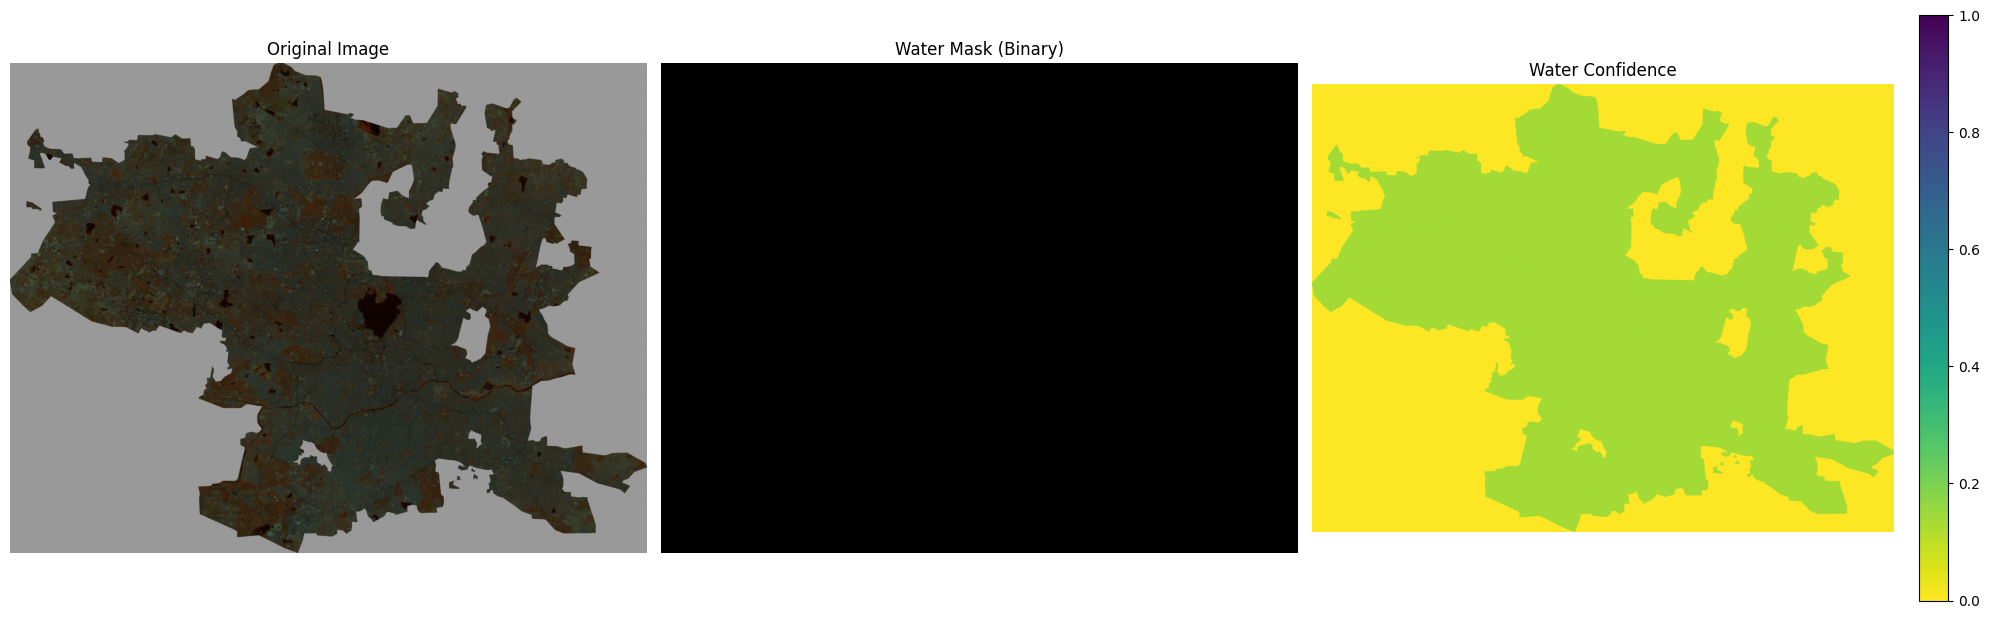

In [ ]:
tif_path = "/content/drive/MyDrive/GHMC/GHMC_S2_new.tif"

# Path to save the output mask
output_path = "water_mask.tif"

# Process the large image
binary_mask, confidence_mask = predict_large_image(
    trained_model,
    tif_path,
    output_path=output_path,
    patch_size=512,
    overlap=64,
    batch_size=4  # Adjust based on your GPU memory
)

# Visualize the results
visualize_results(tif_path, binary_mask, confidence_mask)

In [ ]:
import rasterio
import numpy as np
import os
from math import ceil

def create_rgb_patches(tif_path, output_dir, patch_size=512):
    os.makedirs(output_dir, exist_ok=True)

    with rasterio.open(tif_path) as src:
        width, height = src.width, src.height
        num_bands = src.count

        if num_bands != 3:
            raise ValueError("Expected 3 bands (Band 8, 11, 12) in the TIF file.")

        # Load entire image as float32
        full_data = src.read().astype(np.float32)

        # Compute band-wise mean (ignoring NaNs) and replace NaNs
        for i in range(num_bands):
            band = full_data[i]
            band_mean = np.nanmean(band)
            band[np.isnan(band)] = band_mean
            full_data[i] = band

        # Calculate number of patches
        n_cols = ceil(width / patch_size)
        n_rows = ceil(height / patch_size)

        patch_id = 0
        for i in range(n_rows):
            for j in range(n_cols):
                x_off = j * patch_size
                y_off = i * patch_size
                w = min(patch_size, width - x_off)
                h = min(patch_size, height - y_off)

                # Create RGB patch: R = Band 8, G = Band 11, B = Band 12
                patch_rgb = np.stack([
                    full_data[0, y_off:y_off+h, x_off:x_off+w],  # Red = Band 8
                    full_data[1, y_off:y_off+h, x_off:x_off+w],  # Green = Band 11
                    full_data[2, y_off:y_off+h, x_off:x_off+w],  # Blue = Band 12
                ], axis=0)

                patch_path = os.path.join(output_dir, f"patch_{patch_id}.npy")
                np.save(patch_path, patch_rgb)
                patch_id += 1

    print(f"Saved {patch_id} RGB patches to: {output_dir}")


In [ ]:
create_rgb_patches("/content/drive/MyDrive/GHMC/GHMC_S2_new.tif", "rgb_patches", patch_size=512)


Saved 48 RGB patches to: rgb_patches


In [ ]:
import torchvision.transforms as T

def get_tensor_transform():
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    return T.Compose([
        T.Lambda(lambda x: torch.where(x == -1, torch.tensor(0.0), x)),  # Replace padding with 0
        T.Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8)),  # Normalize to [0, 1]
        T.Normalize(mean=mean.tolist(), std=std.tolist())               # Normalize with standard mean and std
    ])


In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image

class SentinelPatchDataset(Dataset):
    def __init__(self, patch_dir, transform=None):
        self.patch_dir = patch_dir
        self.patch_files = [f for f in os.listdir(patch_dir) if f.endswith(".npy")]
        self.transform = transform

    def __len__(self):
        return len(self.patch_files)

    def __getitem__(self, idx):
        patch_path = os.path.join(self.patch_dir, self.patch_files[idx])
        patch = np.load(patch_path)  # (3, H, W)
        patch = torch.from_numpy(patch).float()
        if self.transform:
            patch = self.transform(patch)
        return patch

def pad_tensor(tensor, pad_size=(512, 512)):
    """Pads a tensor with zeros to the given size."""
    pad_h = pad_size[0] - tensor.shape[-2]
    pad_w = pad_size[1] - tensor.shape[-1]

    # Pad only if necessary
    if pad_h > 0 or pad_w > 0:
        padding = (0, pad_w, 0, pad_h)  # Pad right and bottom
        tensor = torch.nn.functional.pad(tensor, padding, mode='constant', value=-1)

    return tensor

def collate_fn(batch):
    """Custom collate function to pad tensors to 512x512."""
    # Pad each tensor in the batch to 512x512
    padded_batch = [pad_tensor(tensor) for tensor in batch]

    return torch.stack(padded_batch, 0)

def get_dataloader(patch_dir, batch_size=8, shuffle=True, num_workers=0):
    transform = get_tensor_transform()
    dataset = SentinelPatchDataset(patch_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn)
    return dataloader


In [ ]:
patch_dir = "rgb_patches"
dataloader = get_dataloader(patch_dir, batch_size=16)

for batch in dataloader:
    print(batch.shape)
    break


torch.Size([16, 3, 512, 512])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_rgb_tensor(tensor, title=None):

    # Clone and move to CPU if necessary
    img = tensor.clone().detach().cpu().numpy()
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]


    for c in range(3):  # For each channel (RGB)
      img[c] = img[c] * std[c] + mean[c]  # Denormalize

    # Transpose to (H, W, 3) for visualization
    img = np.transpose(img, (1, 2, 0))  # (H, W, 3)

    # Replace padding value (-1) with 0 for visualization
    # img[img == -1] = 0

    # Normalize for display (optional, if values are not 0–1 or 0–255)
    img = (img - img.min()) / (img.max() - img.min())

    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()


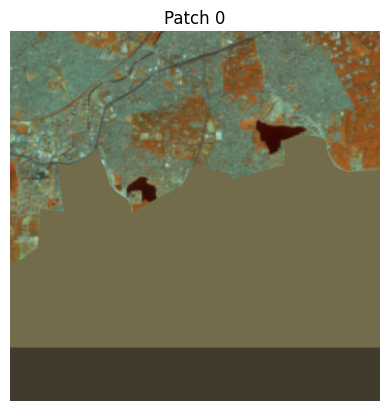

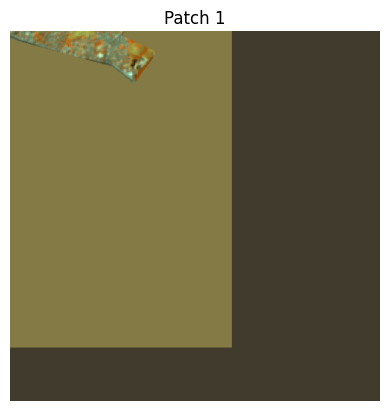

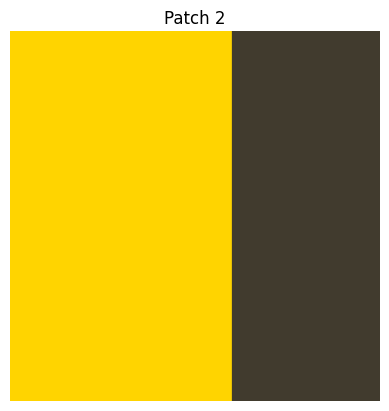

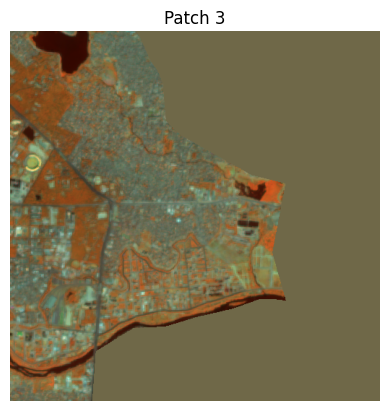

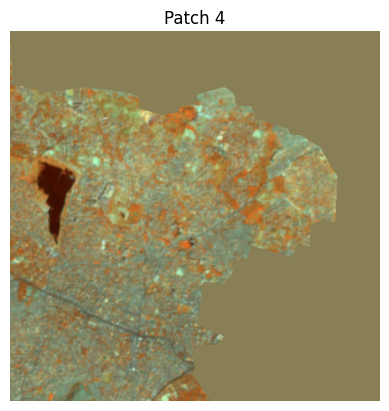

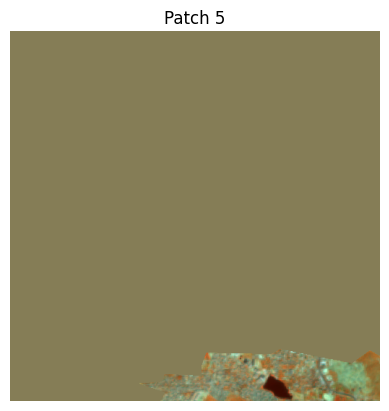

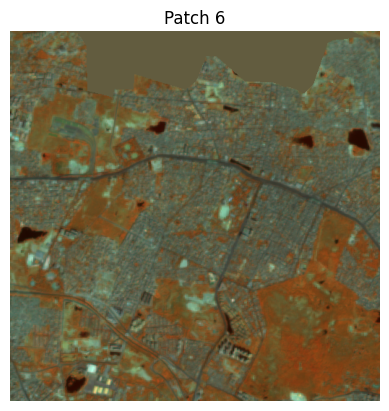

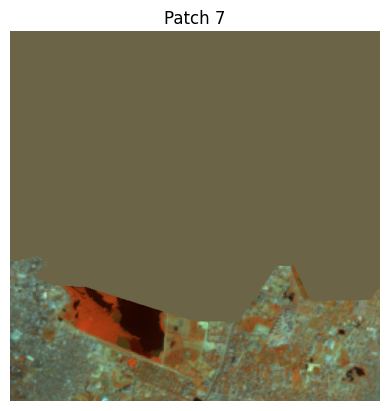

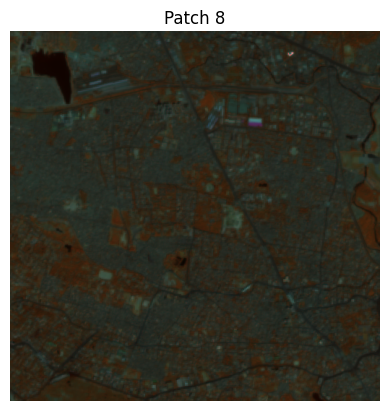

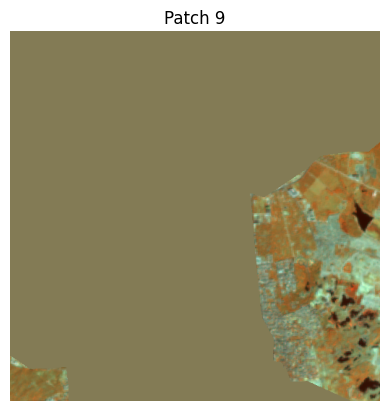

In [ ]:
# Get the first batch
for batch in dataloader:
    for i in range(min(10, batch.size(0))):
        show_rgb_tensor(batch[i], title=f"Patch {i}")
    break


In [ ]:

def predict_labels_for_test(model, dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    all_preds = []  # Store all batch predictions here

    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            outputs = model(images)  # Shape: (B, 1, H, W) or (B, H, W)

            pred_masks = (outputs > 0.5).float()  # Thresholding
            all_preds.append(pred_masks.cpu())  # Move to CPU for accumulation

    # Combine all batches into one tensor: shape (N, 1, H, W)
    all_preds = torch.cat(all_preds, dim=0)
    return all_preds



In [ ]:
all_predictions = predict_labels_for_test(trained_model, dataloader)

print("Combined predictions shape:", all_predictions.shape)



Combined predictions shape: torch.Size([48, 1, 512, 512])


In [ ]:
def reconstruct_from_patches(predicted_patches, original_height, original_width, patch_size=512):
    if predicted_patches.dim() == 4:
        predicted_patches = predicted_patches.squeeze(1)  # (N, H, W)

    predicted_patches = predicted_patches.numpy()

    n_rows = ceil(original_height / patch_size)
    n_cols = ceil(original_width / patch_size)

    full_mask = np.zeros((original_height, original_width), dtype=np.uint8)

    patch_idx = 0
    for i in range(n_rows):
        for j in range(n_cols):
            y_off = i * patch_size
            x_off = j * patch_size

            patch = predicted_patches[patch_idx]
            h, w = patch.shape
            max_y = min(y_off + h, original_height)
            max_x = min(x_off + w, original_width)
            patch_h = max_y - y_off
            patch_w = max_x - x_off

            full_mask[y_off:max_y, x_off:max_x] = (patch[:patch_h, :patch_w] > 0.5).astype(np.uint8)
            patch_idx += 1

    return full_mask


In [ ]:
import rasterio

def get_image_dimensions(tif_path):
    with rasterio.open(tif_path) as src:
        height = src.height
        width = src.width
    return height, width
tif_path = "/content/drive/MyDrive/GHMC/GHMC_S2_new.tif"  # Replace with your actual TIFF path
original_height, original_width = get_image_dimensions(tif_path)
print(f"Original image size: {original_height} × {original_width}")


Original image size: 2998 × 3891
